### Load Mujoco Engine

In [2]:
import mujoco
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("..")
from model.mujoco_parser import MuJoCoParserClass
from model.util import sample_xyzs,rpy2r,r2quat
np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("MuJoCo version:[%s]"%(mujoco.__version__))

MuJoCo version:[2.3.4]


### Parse

In [3]:
xml_path = '../asset/ur5e/scene_ur5e_rg2_obj.xml'
env = MuJoCoParserClass(name='UR5e with RG2 gripper',rel_xml_path=xml_path,VERBOSE=True)
obj_names = [body_name for body_name in env.body_names
             if body_name is not None and (body_name.startswith("obj_"))]
n_obj = len(obj_names)
# Place objects in a row
xyzs = sample_xyzs(n_sample=n_obj,
                   x_range=[0.45,1.65],y_range=[-0.38,0.38],z_range=[0.81,0.81],min_dist=0.2)
colors = np.array([plt.cm.gist_rainbow(x) for x in np.linspace(0,1,n_obj)])
for obj_idx,obj_name in enumerate(obj_names):
    jntadr = env.model.body(obj_name).jntadr[0]
    env.model.joint(jntadr).qpos0[:3] = xyzs[obj_idx,:]
    geomadr = env.model.body(obj_name).geomadr[0]
    env.model.geom(geomadr).rgba = colors[obj_idx] # color

# Move tables and robot base
env.model.body('base_table').pos = np.array([0,0,0])
env.model.body('front_object_table').pos = np.array([1.05,0,0])
env.model.body('side_object_table').pos = np.array([0,-0.85,0])
env.model.body('base').pos = np.array([0,0,0.8])
print ("Ready.")

dt:[0.0020] HZ:[500]
n_body:[52]
geom_names:['floor', None, None, None, None, None, 'shoulder_link', None, None, None, None, 'upper_arm_link_1', 'upper_arm_link_2', None, None, None, None, 'forearm_link_1', 'forearm_link_2', None, None, None, 'wrist_1_link', None, None, None, 'wrist_2_link_1', 'wrist_2_link_2', None, 'wrist_3_link', 'tcp_link', 'camera_mount', 'camera_mounted_gear', 'rg2_gripper_base_link', 'camera_center', 'rg2_gripper_finger1_finger_link', 'rg2_gripper_finger1_inner_knuckle_link', 'rg2_gripper_finger1_finger_tip_link', 'rg2_gripper_finger2_finger_link', 'rg2_gripper_finger2_inner_knuckle_link', 'rg2_gripper_finger2_finger_tip_link', 'front_object_table', 'side_object_table', 'base_table', 'obj_cylinder_01', 'obj_cylinder_02', 'obj_cylinder_03', 'obj_cylinder_04', 'obj_cylinder_05', 'obj_cylinder_06', 'obj_cylinder_07', 'obj_cylinder_08']
n_body:[29]
body_names:['world', 'base', 'shoulder_link', 'upper_arm_link', 'forearm_link', 'wrist_1_link', 'wrist_2_link', 'wrist_

In [4]:
joint_names = env.rev_joint_names[:6]
idxs_forward = [env.model.joint(joint_name).qposadr[0] for joint_name in env.joint_names[:6]]
idxs_jacobian = [env.model.joint(joint_name).dofadr[0] for joint_name in env.joint_names[:6]]
list1, list2 = env.ctrl_joint_idxs, idxs_forward
idxs_step = []
for i in range(len(list2)):
    if list2[i] in list1:
        idxs_step.append(list1.index(list2[i]))
        

In [5]:
joint_value = [-1.570521656666891, -2.311883111993307, 2.1441715399371546, 1.73920385419812, 0.7853929996490479, -1.5711215178119105]

### Solve `General` form of Inverse Kinematics on `Mujoco Engine`
#### Doesn't consider the `collisions`

In [6]:
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=0.0,distance=3.5,elevation=-60,lookat=[0.4,0.05,0.36],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=True,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=True,jointlength=0.5,jointwidth=0.1,jointrgba=[0.2,0.6,0.8,0.6])
env.reset()

R_trgt = rpy2r(np.radians([-180,0,90]))

q_ik = env.solve_ik(
    body_name='tcp_link',p_trgt=np.array([0.7, -0.2, 1.10]),R_trgt=R_trgt,
    IK_P=True,IK_R=True, q_init=np.array(joint_value),idxs_forward=idxs_forward, idxs_jacobian=idxs_jacobian,
    RESET=False,DO_RENDER=True,render_every=1,th=1*np.pi/180.0,err_th=1e-3)

# Close viewer
env.close_viewer()
print ("Done.")

print(q_ik)

Done.
[-0.72 -1.    1.96  2.18 -0.85 -3.14]


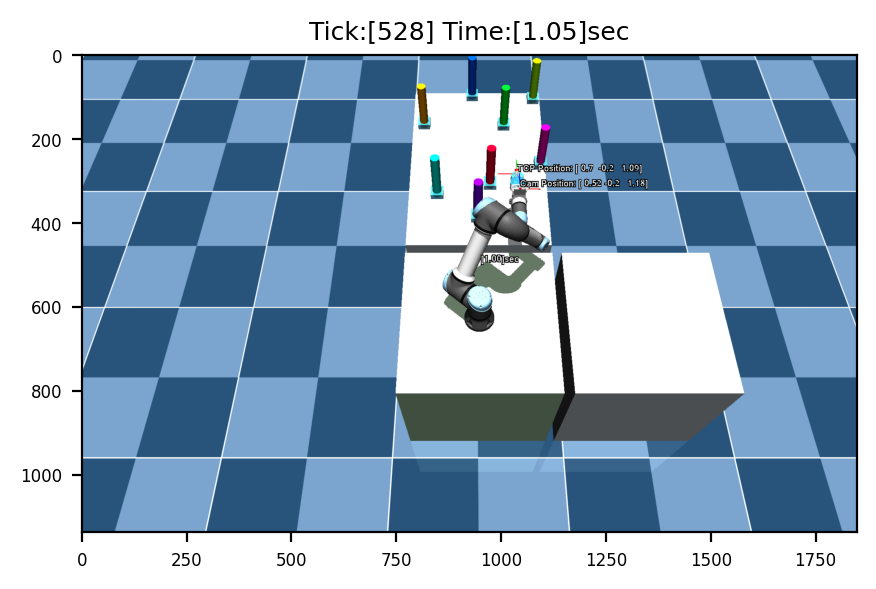

Done.


In [15]:
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=0.0,distance=3.5,elevation=-60,lookat=[0.4,0.05,0.36],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=True,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=True,jointlength=0.5,jointwidth=0.1,jointrgba=[0.2,0.6,0.8,0.6])
env.reset()
env.forward(q=[-1.570521656666891, -2.311883111993307, 2.1441715399371546, 1.73920385419812, 0.7853929996490479, -1.5711215178119105], joint_idxs=idxs_forward)


tick = 0
while (env.get_sim_time() < 100.0) and env.is_viewer_alive():
    tick = tick + 1
    env.step(ctrl=q_ik, ctrl_idxs=idxs_forward)
    # Render
    p_tcp,R_tcp = env.get_pR_body(body_name='tcp_link')
    p_cam,R_cam = env.get_pR_body(body_name='camera_center')
    p_base,R_base = env.get_pR_body(body_name='base')
    # env.plot_T(p=np.zeros(3),R=np.eye(3,3),PLOT_AXIS=True,axis_len=1.0,axis_width=0.01)
    env.plot_T(p=p_tcp,R=R_tcp,PLOT_AXIS=True,axis_len=0.1,axis_width=0.0025,
               label=f'TCP Position: {p_tcp}')
    env.plot_T(p=p_cam,R=R_cam,PLOT_AXIS=True,axis_len=0.1,axis_width=0.0025,
               label=f'Cam Position: {p_cam}')
    # env.plot_T(p=p_base,R=R_base,PLOT_AXIS=True,axis_len=1.0,axis_width=0.01)
    env.plot_T(p=p_base+np.array([0,0,0.5]),R=np.eye(3,3),
                PLOT_AXIS=False,label='[%.2f]sec'%(env.get_sim_time()))
    env.render()
    if env.loop_every(HZ=1) or (tick == 1):
        scene_img = env.grab_image()
# Plot an image
plt.figure(figsize=(5,4)); plt.imshow(scene_img)
plt.title("Tick:[%d] Time:[%.2f]sec"%(env.tick,env.get_sim_time()),fontsize=9)
plt.show()
# Close viewer
env.close_viewer()
print ("Done.")

## `Quintic` trajectory planning

Time: 0.00s
Joint 1: Position: -1.57, Velocity: 0.00, Acceleration: 0.00
Joint 2: Position: -2.31, Velocity: 0.00, Acceleration: 0.00
Joint 3: Position: 2.14, Velocity: 0.00, Acceleration: 0.00
Joint 4: Position: 1.74, Velocity: 0.00, Acceleration: 0.00
Joint 5: Position: 0.79, Velocity: 0.00, Acceleration: 0.00
Joint 6: Position: -1.57, Velocity: 0.00, Acceleration: 0.00
Time: 0.00s
Joint 1: Position: -1.57, Velocity: 0.00, Acceleration: 0.00
Joint 2: Position: -2.31, Velocity: 0.00, Acceleration: 0.00
Joint 3: Position: 2.14, Velocity: -0.00, Acceleration: -0.00
Joint 4: Position: 1.74, Velocity: 0.00, Acceleration: 0.00
Joint 5: Position: 0.79, Velocity: -0.00, Acceleration: -0.00
Joint 6: Position: -1.57, Velocity: -0.00, Acceleration: -0.00
Time: 0.00s
Joint 1: Position: -1.57, Velocity: 0.00, Acceleration: 0.00
Joint 2: Position: -2.31, Velocity: 0.00, Acceleration: 0.00
Joint 3: Position: 2.14, Velocity: -0.00, Acceleration: -0.00
Joint 4: Position: 1.74, Velocity: 0.00, Acceler

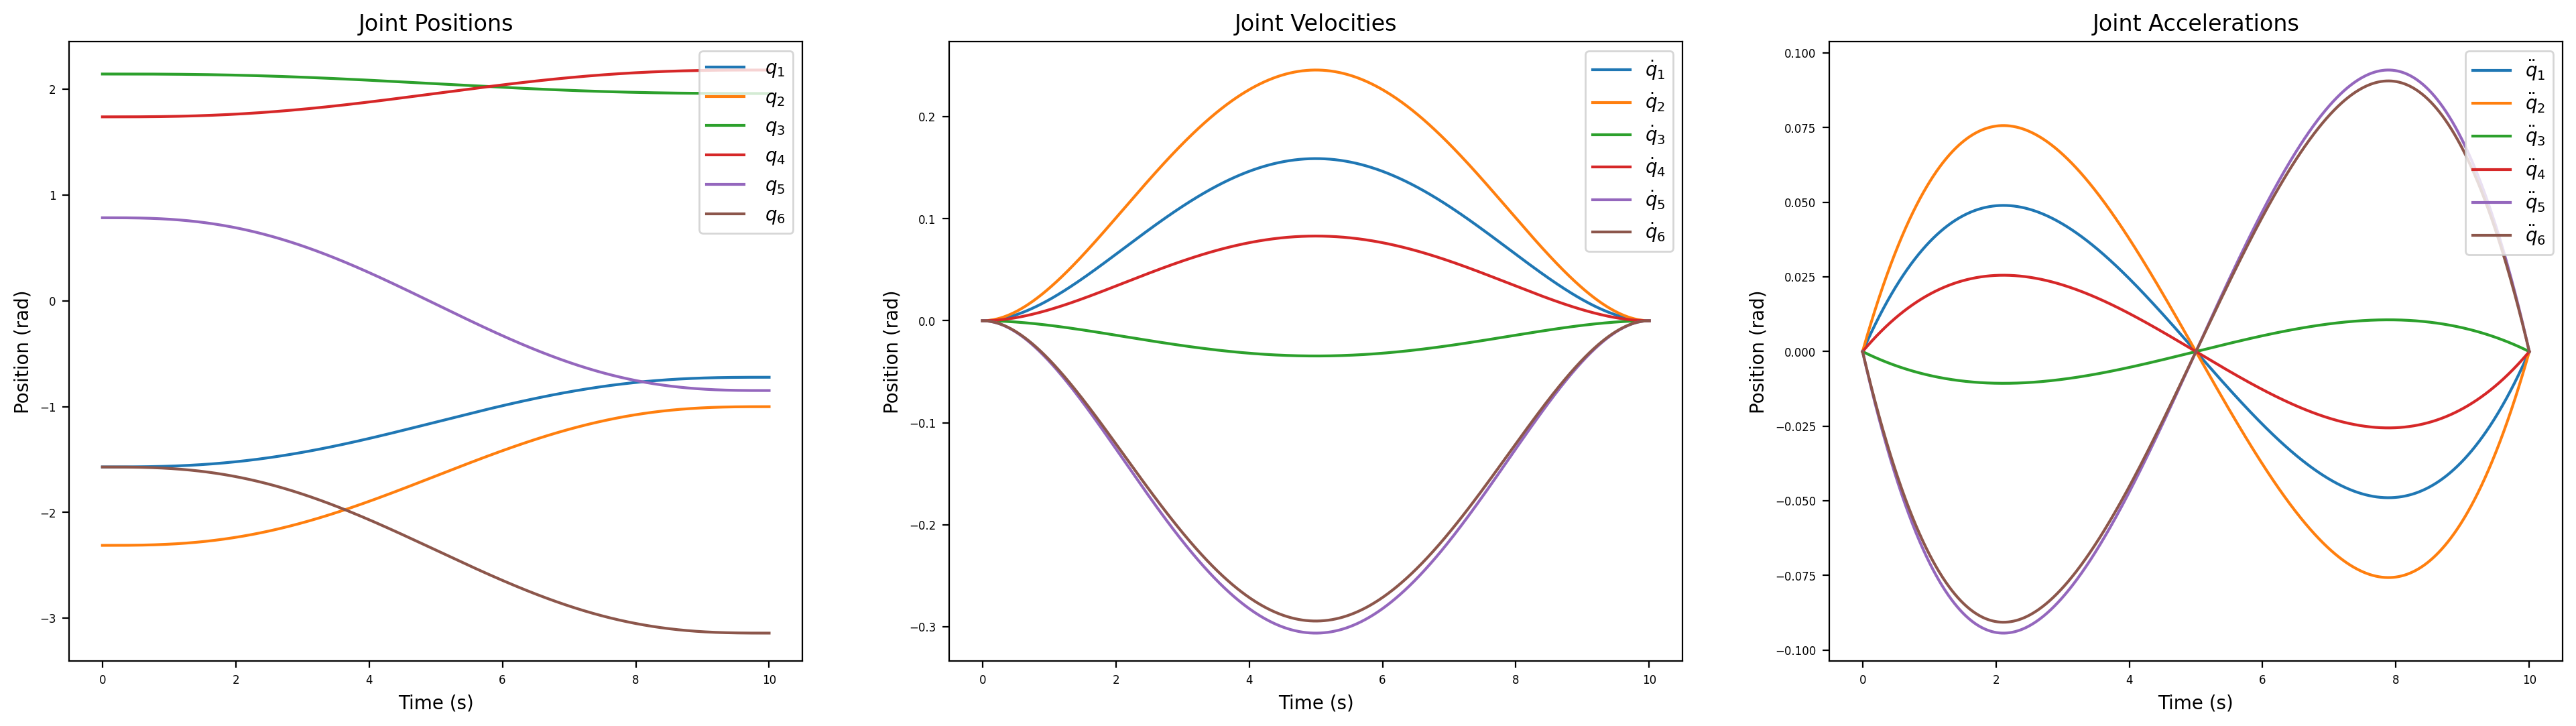

In [44]:
import numpy as np

def quintic_trajectory(start_pos, start_vel, start_acc, end_pos, end_vel, end_acc, duration, num_points, max_velocity, max_acceleration):
    # Compute time intervals
    t = np.linspace(0, duration, num_points)

    # Compute polynomial coefficients for each joint
    coeffs = []
    for i in range(6):
        A = np.array([[0, 0, 0, 0, 0, 1],
                      [0, 0, 0, 0, 1, 0],
                      [0, 0, 0, 2, 0, 0],
                      [duration**5, duration**4, duration**3, duration**2, duration, 1],
                      [5*duration**4, 4*duration**3, 3*duration**2, 2*duration, 1, 0],
                      [20*duration**3, 12*duration**2, 6*duration, 2, 0, 0]])

        b = np.array([start_pos[i], start_vel[i], start_acc[i], end_pos[i], end_vel[i], end_acc[i]])

        # Solve for polynomial coefficients
        x = np.linalg.solve(A, b)
        coeffs.append(x)

    # Generate trajectory points for each joint
    positions = np.zeros((num_points, 6))
    velocities = np.zeros((num_points, 6))
    accelerations = np.zeros((num_points, 6))

    for i in range(num_points):
        for j in range(6):
            positions[i, j] = np.polyval(coeffs[j], t[i])   # Compute 0th derivative
            velocities[i, j] = np.polyval(np.polyder(coeffs[j]), t[i])  # Compute 1st derivative
            accelerations[i, j] = np.polyval(np.polyder(np.polyder(coeffs[j])), t[i])   # Compute 2nd derivative

    # Apply velocity and acceleration constraints
    velocities = np.clip(velocities, -max_velocity, max_velocity)
    accelerations = np.clip(accelerations, -max_acceleration, max_acceleration)

    return positions, velocities, accelerations

# Define the conditions of the trajectory
start_pos = joint_value
start_vel = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
start_acc = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
end_pos = q_ik
end_vel = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
end_acc = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
duration = 10.0
num_points = int(duration / env.dt)
max_velocity = 1.0
max_acceleration = 1.0

positions, velocities, accelerations = quintic_trajectory(start_pos, start_vel, start_acc, end_pos, end_vel, end_acc, duration, num_points, max_velocity, max_acceleration)

# Print the generated trajectory points for each joint
for i in range(num_points):
    print(f"Time: {i * duration / num_points:.2f}s")
    for j in range(6):
        print(f"Joint {j+1}: Position: {positions[i, j]:.2f}, Velocity: {velocities[i, j]:.2f}, Acceleration: {accelerations[i, j]:.2f}")

time_step = np.linspace(0, duration, num_points)
plt.figure(figsize=(24, 6))
plt.subplot(1, 3, 1)
for i in range(6):
    plt.plot(time_step, positions[:, i], label=rf"$\ q_{i+1}$")
    # plt.plot(time_step, velocities[:, i], label=f"Velocity: {i+1}")
    # plt.plot(time_step, accelerations[:, i], label=f"Acceleration: {i+1}")

plt.xlabel("Time (s)")
plt.ylabel("Position (rad)")
plt.title("Joint Positions")
plt.legend(loc='upper right')
# plt.show()

plt.subplot(1, 3, 2)
for i in range(6):
    plt.plot(time_step, velocities[:, i], label=rf"$\dot q_{i+1}$")
plt.xlabel("Time (s)")
plt.ylabel("Position (rad)")
plt.title("Joint Velocities")
plt.legend(loc='upper right')
# plt.show()

plt.subplot(1, 3, 3)
for i in range(6):
    plt.plot(time_step, accelerations[:, i], label=rf"$\ddot q_{i+1}$")

plt.xlabel("Time (s)")
plt.ylabel("Position (rad)")
plt.title("Joint Accelerations")
plt.legend(loc='upper right')
plt.show()

Pressed ESC
Quitting.


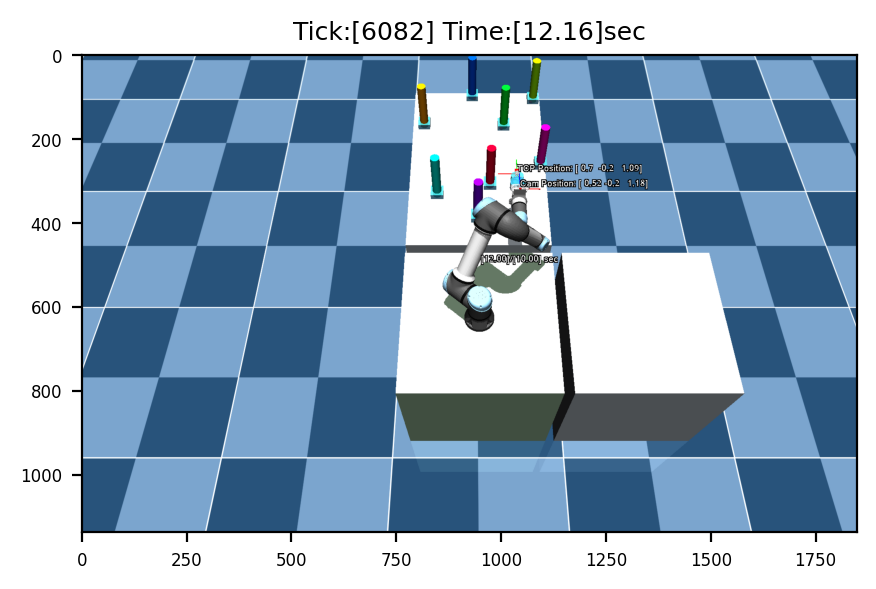

Done.


In [45]:
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=0.0,distance=3.5,elevation=-60,lookat=[0.4,0.05,0.36],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=True,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=True,jointlength=0.5,jointwidth=0.1,jointrgba=[0.2,0.6,0.8,0.6])
env.reset()
env.forward(q=[-1.570521656666891, -2.311883111993307, 2.1441715399371546, 1.73920385419812, 0.7853929996490479, -1.5711215178119105], joint_idxs=idxs_forward)


tick = 0
while (env.get_sim_time() < 100.0) and env.is_viewer_alive():
    tick = tick + 1
    if tick >= num_points:
        env.step(ctrl=positions[-1,:], ctrl_idxs=idxs_forward)
    else:    
        env.step(ctrl=positions[tick,:], ctrl_idxs=idxs_forward)
        
    # Render
    p_tcp,R_tcp = env.get_pR_body(body_name='tcp_link')
    p_cam,R_cam = env.get_pR_body(body_name='camera_center')
    p_base,R_base = env.get_pR_body(body_name='base')
    # env.plot_T(p=np.zeros(3),R=np.eye(3,3),PLOT_AXIS=True,axis_len=1.0,axis_width=0.01)
    env.plot_T(p=p_tcp,R=R_tcp,PLOT_AXIS=True,axis_len=0.1,axis_width=0.0025,
               label=f'TCP Position: {p_tcp}')
    env.plot_T(p=p_cam,R=R_cam,PLOT_AXIS=True,axis_len=0.1,axis_width=0.0025,
               label=f'Cam Position: {p_cam}')
    # env.plot_T(p=p_base,R=R_base,PLOT_AXIS=True,axis_len=1.0,axis_width=0.01)
    env.plot_T(p=p_base+np.array([0,0,0.5]),R=np.eye(3,3),
                PLOT_AXIS=False,label='[%.2f]/[%.2f] sec'%(env.get_sim_time(), duration))
    env.render()
    if env.loop_every(HZ=1) or (tick == 1):
        scene_img = env.grab_image()
# Plot an image
plt.figure(figsize=(5,4)); plt.imshow(scene_img)
plt.title("Tick:[%d] Time:[%.2f]sec"%(env.tick,env.get_sim_time()),fontsize=9)
plt.show()
# Close viewer
env.close_viewer()
print ("Done.")

### Minimum `Jerk` trajectory planning

Minimum Jerk Trajectory Generator


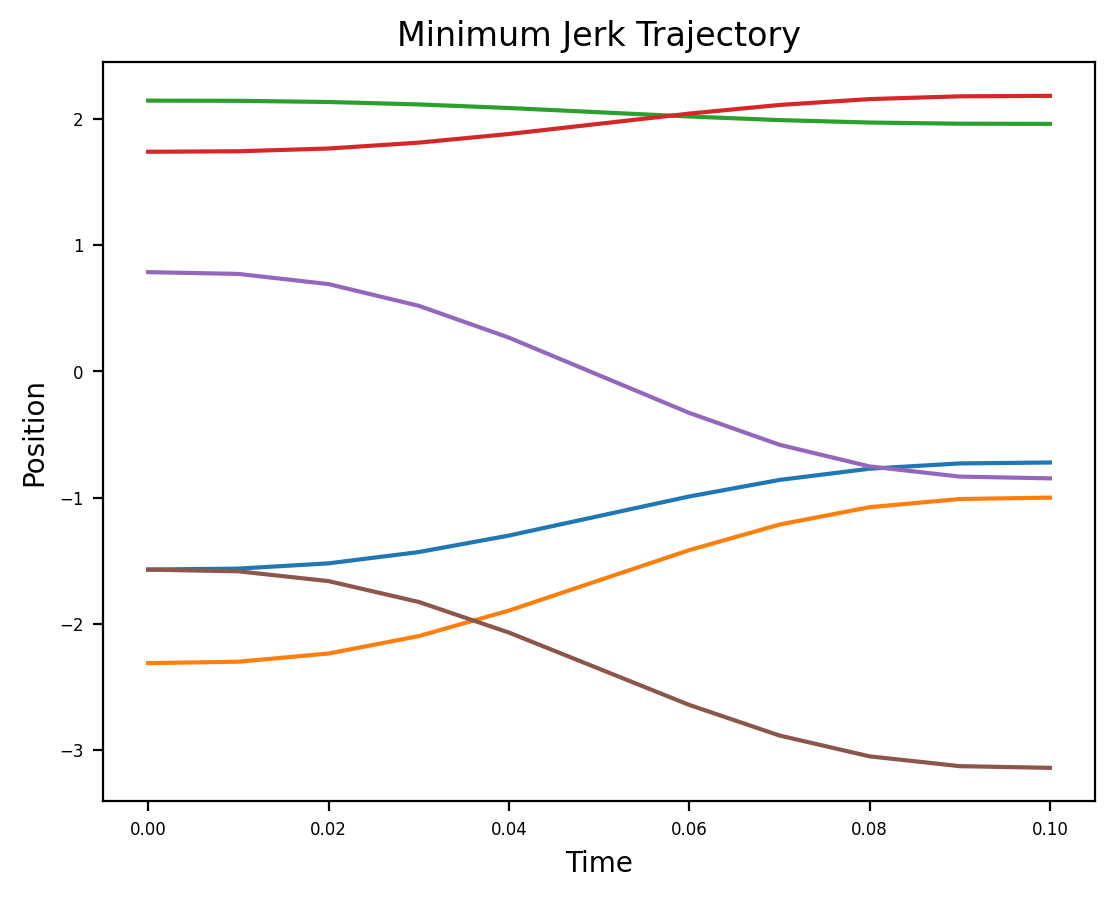

In [80]:
import numpy as np 
import matplotlib.pyplot as plt

def minimum_jerk_trajectory(init_pos, target_pos, total_time=0.5, dt=0.01):
    q_init = init_pos
    q_final = target_pos
    duration = total_time
    list_t = []
    list_q = []
    t = 0
    while t < duration:
        q = q_init + (q_final-q_init) * (10*(t/duration)**3 - 15*(t/duration)**4 + 6*(t/duration)**5)
        list_t.append(t)
        list_q.append(q)
        t += dt
    return np.array(list_t), np.array(list_q)

print("Minimum Jerk Trajectory Generator")
# This is initial position of servo motor
init_pos = joint_value
# This is target position of servo motor
target_pos = q_ik
# We want to move all joint from initial to target position in 1 seconds
t, q_traj_jerk = minimum_jerk_trajectory(init_pos, target_pos, total_time=.10)
# Show the result
fig, ax = plt.subplots()
ax.plot(t, q_traj_jerk)
ax.set_title("Minimum Jerk Trajectory")
ax.set_xlabel("Time")
ax.set_ylabel("Position")
plt.show()


Pressed ESC
Quitting.


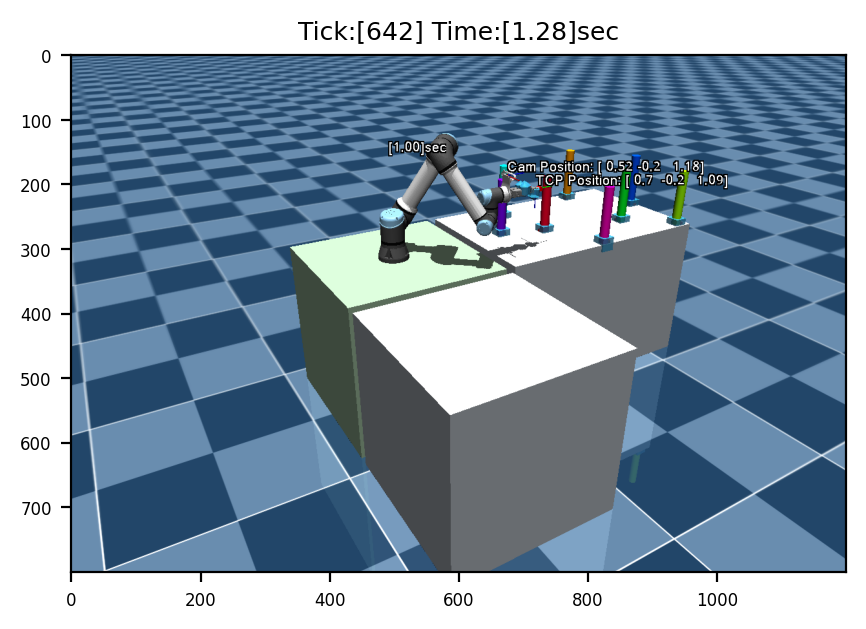

Done.


In [81]:
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=0.0,distance=3.5,elevation=-60,lookat=[0.4,0.05,0.36],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=True,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=True,jointlength=0.5,jointwidth=0.1,jointrgba=[0.2,0.6,0.8,0.6])
env.reset()
env.forward(q=[-1.570521656666891, -2.311883111993307, 2.1441715399371546, 1.73920385419812, 0.7853929996490479, -1.5711215178119105], joint_idxs=idxs_forward)


tick = 0
while (env.get_sim_time() < 100.0) and env.is_viewer_alive():
    tick = tick + 1
    if tick >= q_traj_jerk.shape[0]:
        env.step(ctrl=q_traj_jerk[-1,:], ctrl_idxs=idxs_forward)
    else:    
        env.step(ctrl=q_traj_jerk[tick,:], ctrl_idxs=idxs_forward)
        
    # Render
    p_tcp,R_tcp = env.get_pR_body(body_name='tcp_link')
    p_cam,R_cam = env.get_pR_body(body_name='camera_center')
    p_base,R_base = env.get_pR_body(body_name='base')
    # env.plot_T(p=np.zeros(3),R=np.eye(3,3),PLOT_AXIS=True,axis_len=1.0,axis_width=0.01)
    env.plot_T(p=p_tcp,R=R_tcp,PLOT_AXIS=True,axis_len=0.1,axis_width=0.0025,
               label=f'TCP Position: {p_tcp}')
    env.plot_T(p=p_cam,R=R_cam,PLOT_AXIS=True,axis_len=0.1,axis_width=0.0025,
               label=f'Cam Position: {p_cam}')
    # env.plot_T(p=p_base,R=R_base,PLOT_AXIS=True,axis_len=1.0,axis_width=0.01)
    env.plot_T(p=p_base+np.array([0,0,0.5]),R=np.eye(3,3),
                PLOT_AXIS=False,label='[%.2f]sec'%(env.get_sim_time()))
    env.render()
    if env.loop_every(HZ=1) or (tick == 1):
        scene_img = env.grab_image()
# Plot an image
plt.figure(figsize=(5,4)); plt.imshow(scene_img)
plt.title("Tick:[%d] Time:[%.2f]sec"%(env.tick,env.get_sim_time()),fontsize=9)
plt.show()
# Close viewer
env.close_viewer()
print ("Done.")

## `Trapezoidal` velocity profile

Time: 0.00s
Joint 1: Position: -1.57, Velocity: 0.00, Acceleration: 0.00
Joint 2: Position: -2.31, Velocity: 0.00, Acceleration: 0.00
Joint 3: Position: 2.14, Velocity: 0.00, Acceleration: 0.00
Joint 4: Position: 1.74, Velocity: 0.00, Acceleration: 0.00
Joint 5: Position: 0.79, Velocity: 0.00, Acceleration: 0.00
Joint 6: Position: -1.57, Velocity: 0.00, Acceleration: 0.00
Time: 0.00s
Joint 1: Position: -1.57, Velocity: 0.00, Acceleration: 0.00
Joint 2: Position: -2.31, Velocity: 0.00, Acceleration: 0.00
Joint 3: Position: 2.14, Velocity: 0.00, Acceleration: 0.00
Joint 4: Position: 1.74, Velocity: 0.00, Acceleration: 0.00
Joint 5: Position: 0.79, Velocity: 0.00, Acceleration: 0.00
Joint 6: Position: -1.57, Velocity: 0.00, Acceleration: 0.00
Time: 0.00s
Joint 1: Position: -1.57, Velocity: 0.00, Acceleration: 0.00
Joint 2: Position: -2.31, Velocity: 0.00, Acceleration: 0.00
Joint 3: Position: 2.14, Velocity: 0.00, Acceleration: 0.00
Joint 4: Position: 1.74, Velocity: 0.00, Acceleration: 0

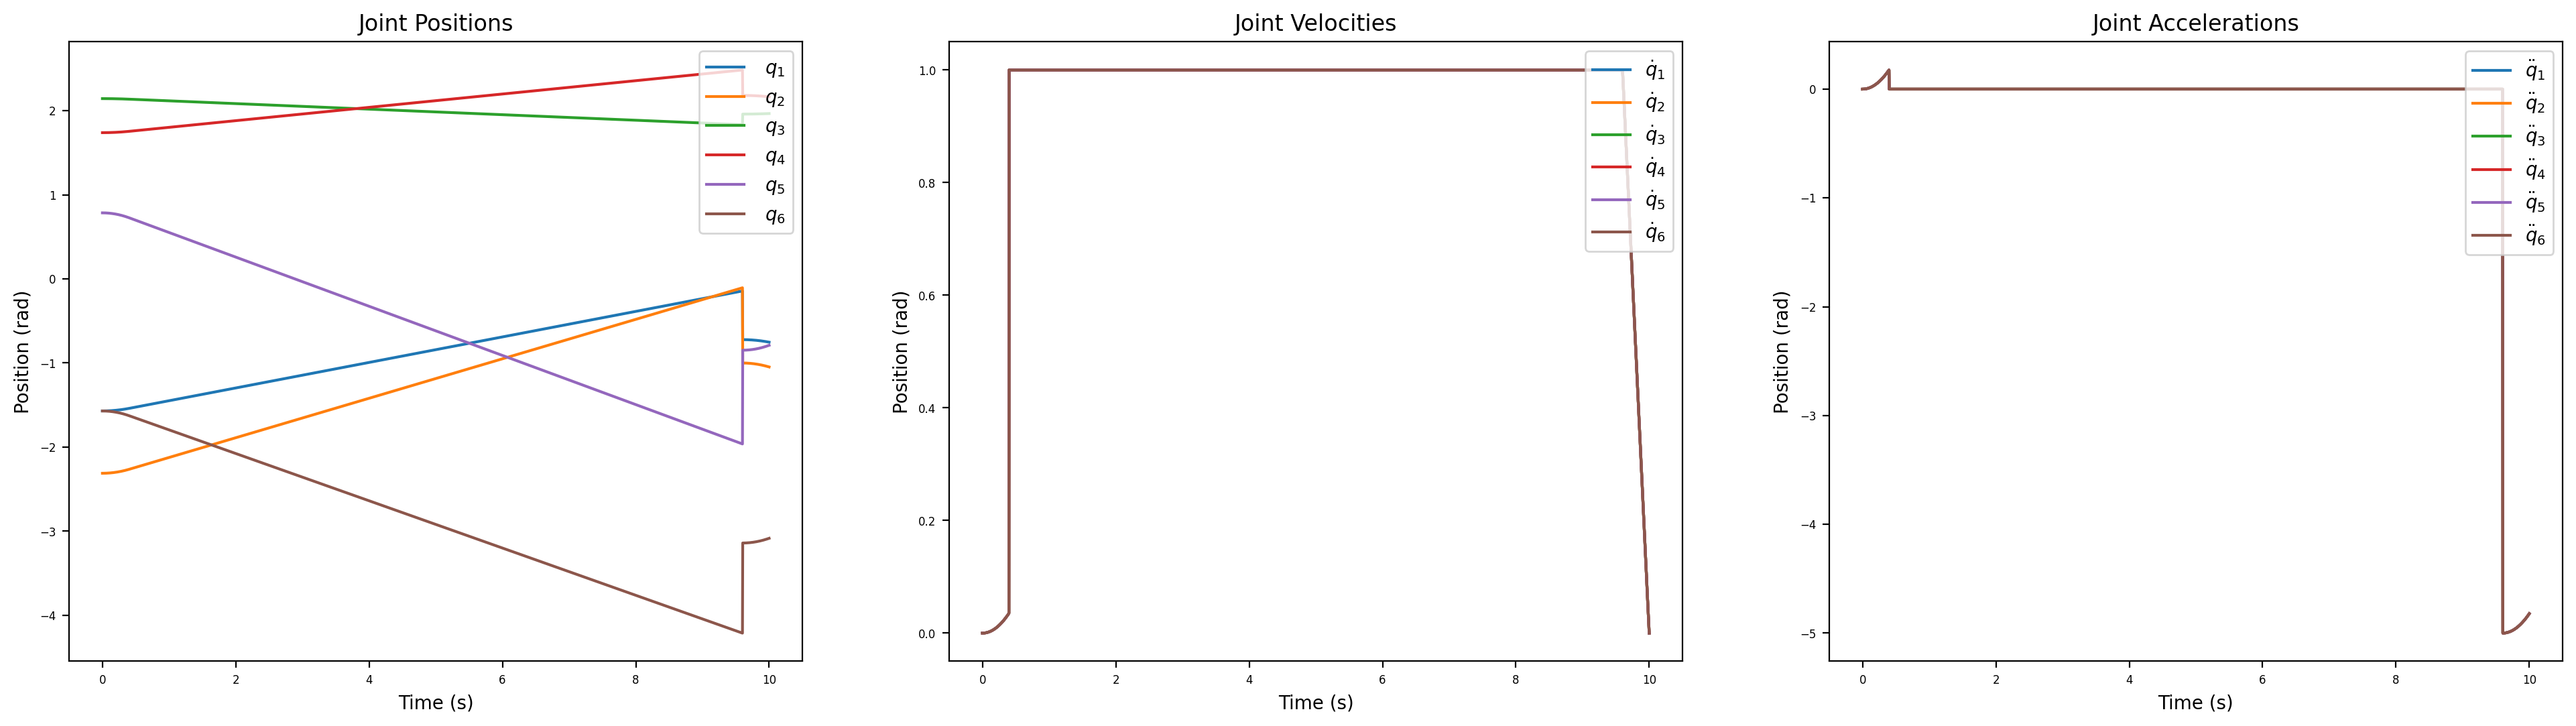

In [88]:
import numpy as np

def velocity_trapezoidal_profile(start_pos, end_pos, max_velocity, max_acceleration, total_time, num_points):
    distance = np.linalg.norm(end_pos - start_pos)

    # Calculate the time required to reach the maximum velocity
    t_acc = max_velocity / max_acceleration

    # Calculate the distance covered during acceleration and deceleration
    distance_acc_dec = 0.5 * max_acceleration * t_acc ** 2

    # Check if the distance is sufficient for both acceleration and deceleration phases
    if distance > 2 * distance_acc_dec:
        # Calculate the maximum constant velocity phase distance
        distance_const_vel = distance - 2 * distance_acc_dec

        # Calculate the time required for the constant velocity phase
        t_const_vel = distance_const_vel / max_velocity

        # Generate time intervals
        t = np.linspace(0, total_time, num_points)

        # Generate position profile
        positions = np.zeros((num_points, 6))
        velocities = np.zeros((num_points, 6))
        accelerations = np.zeros((num_points, 6))

        for i, time in enumerate(t):
            if time <= t_acc:
                # Acceleration phase
                factor = 0.5 * max_acceleration * time ** 2 / distance
                positions[i] = start_pos + factor * (end_pos - start_pos)
                velocities[i] = factor * max_velocity
                accelerations[i] = max_acceleration * factor
            elif time <= (total_time - t_acc):
                # Constant velocity phase
                t_const = time - t_acc
                factor = (distance_acc_dec + max_velocity * t_const) / distance
                positions[i] = start_pos + factor * (end_pos - start_pos)
                velocities[i] = max_velocity
                accelerations[i] = 0.0
            else:
                # Deceleration phase
                t_dec = time - (total_time - t_acc)
                factor = (distance - 0.5 * max_acceleration * t_dec ** 2) / distance
                positions[i] = start_pos + factor * (end_pos - start_pos)
                velocities[i] = max_acceleration * (total_time - time) * factor
                accelerations[i] = -max_acceleration * factor

        return positions, velocities, accelerations

    else:
        # Distance is insufficient for trapezoidal profile, use triangular profile instead
        t_triangular = np.sqrt(2 * distance / max_acceleration)

        # Generate time intervals
        t = np.linspace(0, t_triangular, num_points)

        # Generate position profile
        positions = start_pos + 0.5 * max_acceleration * t ** 2 / distance * (end_pos - start_pos)
        velocities = max_acceleration * t / distance * (end_pos - start_pos)
        accelerations = max_acceleration * np.ones((num_points, 6))

        return positions, velocities, accelerations

# Example usage
start_pos = joint_value
end_pos = q_ik
max_velocity = 1.0
max_acceleration = 5.0
total_time = 5.0  # Manually specified total time
num_points = int(total_time / env.dt)

positions, velocities, accelerations = velocity_trapezoidal_profile(start_pos, end_pos, max_velocity, max_acceleration, total_time, num_points)

# Print the generated profiles for each joint
for i in range(num_points):
    print(f"Time: {i * total_time / num_points:.2f}s")
    for j in range(6):
        print(f"Joint {j+1}: Position: {positions[i, j]:.2f}, Velocity: {velocities[i, j]:.2f}, Acceleration: {accelerations[i, j]:.2f}")


time_step = np.linspace(0, duration, num_points)
plt.figure(figsize=(24, 6))
plt.subplot(1, 3, 1)
for i in range(6):
    plt.plot(time_step, positions[:, i], label=rf"$\ q_{i+1}$")
plt.xlabel("Time (s)")
plt.ylabel("Position (rad)")
plt.title("Joint Positions")
plt.legend(loc='upper right')
# plt.show()

plt.subplot(1, 3, 2)
for i in range(6):
    plt.plot(time_step, velocities[:, i], label=rf"$\dot q_{i+1}$")
plt.xlabel("Time (s)")
plt.ylabel("Position (rad)")
plt.title("Joint Velocities")
plt.legend(loc='upper right')
# plt.show()

plt.subplot(1, 3, 3)
for i in range(6):
    plt.plot(time_step, accelerations[:, i], label=rf"$\ddot q_{i+1}$")

plt.xlabel("Time (s)")
plt.ylabel("Position (rad)")
plt.title("Joint Accelerations")
plt.legend(loc='upper right')
plt.show()

Pressed ESC
Quitting.


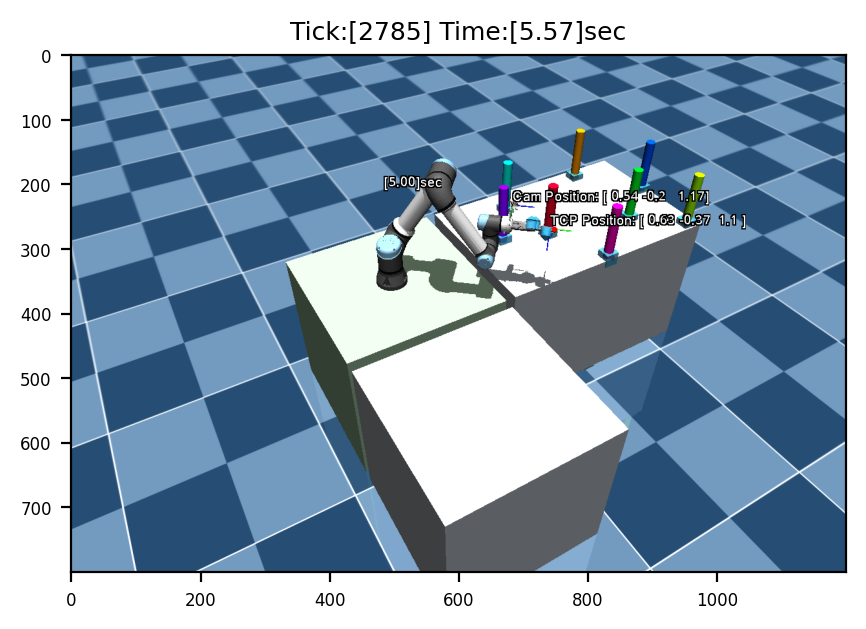

Done.


In [84]:
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=0.0,distance=3.5,elevation=-60,lookat=[0.4,0.05,0.36],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=True,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=True,jointlength=0.5,jointwidth=0.1,jointrgba=[0.2,0.6,0.8,0.6])
env.reset()
env.forward(q=[-1.570521656666891, -2.311883111993307, 2.1441715399371546, 1.73920385419812, 0.7853929996490479, -1.5711215178119105], joint_idxs=idxs_forward)


tick = 0
while (env.get_sim_time() < 100.0) and env.is_viewer_alive():
    tick = tick + 1
    if tick >= num_points:
        env.step(ctrl=positions[-1,:], ctrl_idxs=idxs_forward)
    else:    
        env.step(ctrl=positions[tick,:], ctrl_idxs=idxs_forward)
    # Render
    p_tcp,R_tcp = env.get_pR_body(body_name='tcp_link')
    p_cam,R_cam = env.get_pR_body(body_name='camera_center')
    p_base,R_base = env.get_pR_body(body_name='base')
    # env.plot_T(p=np.zeros(3),R=np.eye(3,3),PLOT_AXIS=True,axis_len=1.0,axis_width=0.01)
    env.plot_T(p=p_tcp,R=R_tcp,PLOT_AXIS=True,axis_len=0.1,axis_width=0.0025,
               label=f'TCP Position: {p_tcp}')
    env.plot_T(p=p_cam,R=R_cam,PLOT_AXIS=True,axis_len=0.1,axis_width=0.0025,
               label=f'Cam Position: {p_cam}')
    # env.plot_T(p=p_base,R=R_base,PLOT_AXIS=True,axis_len=1.0,axis_width=0.01)
    env.plot_T(p=p_base+np.array([0,0,0.5]),R=np.eye(3,3),
                PLOT_AXIS=False,label='[%.2f]sec'%(env.get_sim_time()))
    env.render()
    if env.loop_every(HZ=1) or (tick == 1):
        scene_img = env.grab_image()
# Plot an image
plt.figure(figsize=(5,4)); plt.imshow(scene_img)
plt.title("Tick:[%d] Time:[%.2f]sec"%(env.tick,env.get_sim_time()),fontsize=9)
plt.show()
# Close viewer
env.close_viewer()
print ("Done.")